This notebook contains code to plot SISTR CDFs separated by optimal allele

In [1]:
%pylab inline
import glob
import numpy as np
import sys
import seaborn as sns
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
PLOTDIR = '/storage/BonnieH/selection_project/figures/supp_figures/cdfs_opt_allele/'

Populating the interactive namespace from numpy and matplotlib


/storage/BonnieH/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# PLot cdf of gamma distribution posterior estimates for real data

def main():
    print('Running main')
    
    folder = 'motif_analysis_diff_mu_071921'
    fig_num = 0
    pers = [2,3,4] 
    color_list = ['red','orange','lawngreen','forestgreen','turquoise','blue','purple','brown','slategray','yellow','gold']
    
    motif_dic = {}
    motif_dic[2] = ['AC','AG','AT']
    motif_dic[3] = ['ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT']
    motif_dic[4] = ['AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG']
    
    subplots_dic = {}
    subplots_dic[2] = [(3,4,1),(3,4,2),(3,4,3),(3,4,4),(3,4,5),(3,4,6),(3,4,7),(3,4,8),(3,4,10),(3,4,11)]
    subplots_dic[3] = [(3,3,1),(3,3,2),(3,3,3),(3,3,4),(3,3,5),(3,3,6),(3,3,7),(3,3,8),(3,3,9)]
    subplots_dic[4] = [(2,2,1),(2,2,2),(2,2,3),(2,2,4)]
    
    opt_dic = {}
    opt_dic[2] = range(11,21,1) 
    opt_dic[3] = range(5,14,1)
    opt_dic[4] = range(7,11,1)
    
    color_dic_motif={}
    
    for per in pers:
        i = -1
        for motif in motif_dic[per]:
            i = i + 1
            color_dic_motif[motif] = color_list[i]
    
    color_dic_opt={}
    for per in pers:
        i = -1
        for opt in opt_dic[per]:
            i = i + 1
            color_dic_opt[(per, opt)] = color_list[i]
            
    # Plot motifs (sep graph for each opt allele)
    for l in range(0, 1):
        for per in pers:
            opt_alleles = opt_dic[per]
            print('Period %d'%(per))
            fig_num = fig_num + 1
            fig = plt.figure(fig_num)
            if per != 2:
                fig.set_size_inches((15, 15))
            else:
                fig.set_size_inches((20,15))

            index = -1
            for opt in opt_alleles:
                opt_string = str(opt)
                if opt < 10:
                    opt_string = '0' + opt_string
                
                file_list = glob.glob('/gymreklab-tscc/bonnieh/joint_method/results_top_x/%s/per_%d*_opt_%s.txt'%(folder, per, opt_string))
                file_list.sort() 

                base_plot = ''
                cum_dic = {}
                cum_dic_per_locus = {}

                for filename in file_list:

                    results_file = open(filename, 'r')
                    lines = results_file.readlines()
                    line = lines[4]
                    info = line.strip().split(': ')
                    num_acc = int(info[1])
                    line = lines[1]
                    info = line.strip().split(': ')
                    num_loci = info[1]
                    num_loci = num_loci.strip().split(' ')
                    num_loci = int(num_loci[0])

                    if num_acc > 0 and num_loci >= 0:

                        line = lines[2]
                        info = line.strip().split(': ')
                        motif = info[2]
                        motif = motif.strip().split(' ')
                        motif = motif[0]
                        opt_allele = int(info[3])

                        if motif != '1.0' and motif != '0.0':
                            line = lines[6]
                            info = line.strip().split(',')
                            k = float(info[0])
                            theta = float(info[1])

                            s = [] # List of s values drawn from gamma distribution
                            num_sims = num_loci#1000
                            for i in range(0, num_sims):
                                s_val = np.random.gamma(k, theta)
                                if s_val > 0.1:
                                    s_val = 0.1

                                s.append(s_val)

                            bins_list = [0]
                            exponents = [10**-5, 10**-4, 10**-3, 10**-2]
                            for j in exponents:
                                for i in np.arange(1,10,0.01):
                                    bins_list.append(i*j)

                            bins_list.append(0.1)
                            bins_list.append(1)

                            values, base = np.histogram(s, bins=bins_list)
                            cumulative = list(np.cumsum(values))
                            maximum = max(cumulative)
                            cumulative_scaled = []
                            for elem in cumulative:
                                elem = elem/maximum
                                cumulative_scaled.append(elem)

                            cum_dic[(motif, opt_allele, num_loci)] = cumulative_scaled
                            base_plot = base
                           
                # Plot CDF

                index = index + 1
                ax = fig.add_subplot(subplots_dic[per][index][0],subplots_dic[per][index][1],subplots_dic[per][index][2])
                for elem in cum_dic:

                    if elem[1] != 0:
                        ax.plot(base_plot[:-1], cum_dic[elem], label = elem[0], color=color_dic_motif[elem[0]], linewidth = 3, ls='dashed') # + ' Joint'# (' + str(elem[2]) + ' loci)

                    else:
                        ax.plot(base_plot[:-1], cum_dic[elem], label = elem[0] + ' all opt', color='black', linewidth = 3)

                ax.set_xlim(10**-5, 0.1)
                ax.set_xscale('log')
                ax.set_title( 'Per ' + str(per) + ' Opt allele ' + str(elem[1]),fontsize=15) #'Distribution of s values: per-locus method\n' +
                ax.set_xlabel('s', fontsize=15)
                ax.legend(bbox_to_anchor=(1, 1),fontsize=15) 
                ax.set_ylabel('Cumulative Frequency',fontsize=15)
                plt.xticks(fontsize=15) 
                plt.yticks(fontsize=15)

            fig.tight_layout()
            plt.savefig(PLOTDIR + 'CDF_per_%d.pdf'%(per),bbox_inches='tight')
            plt.show()
        print('Done')

Running main
Period 2


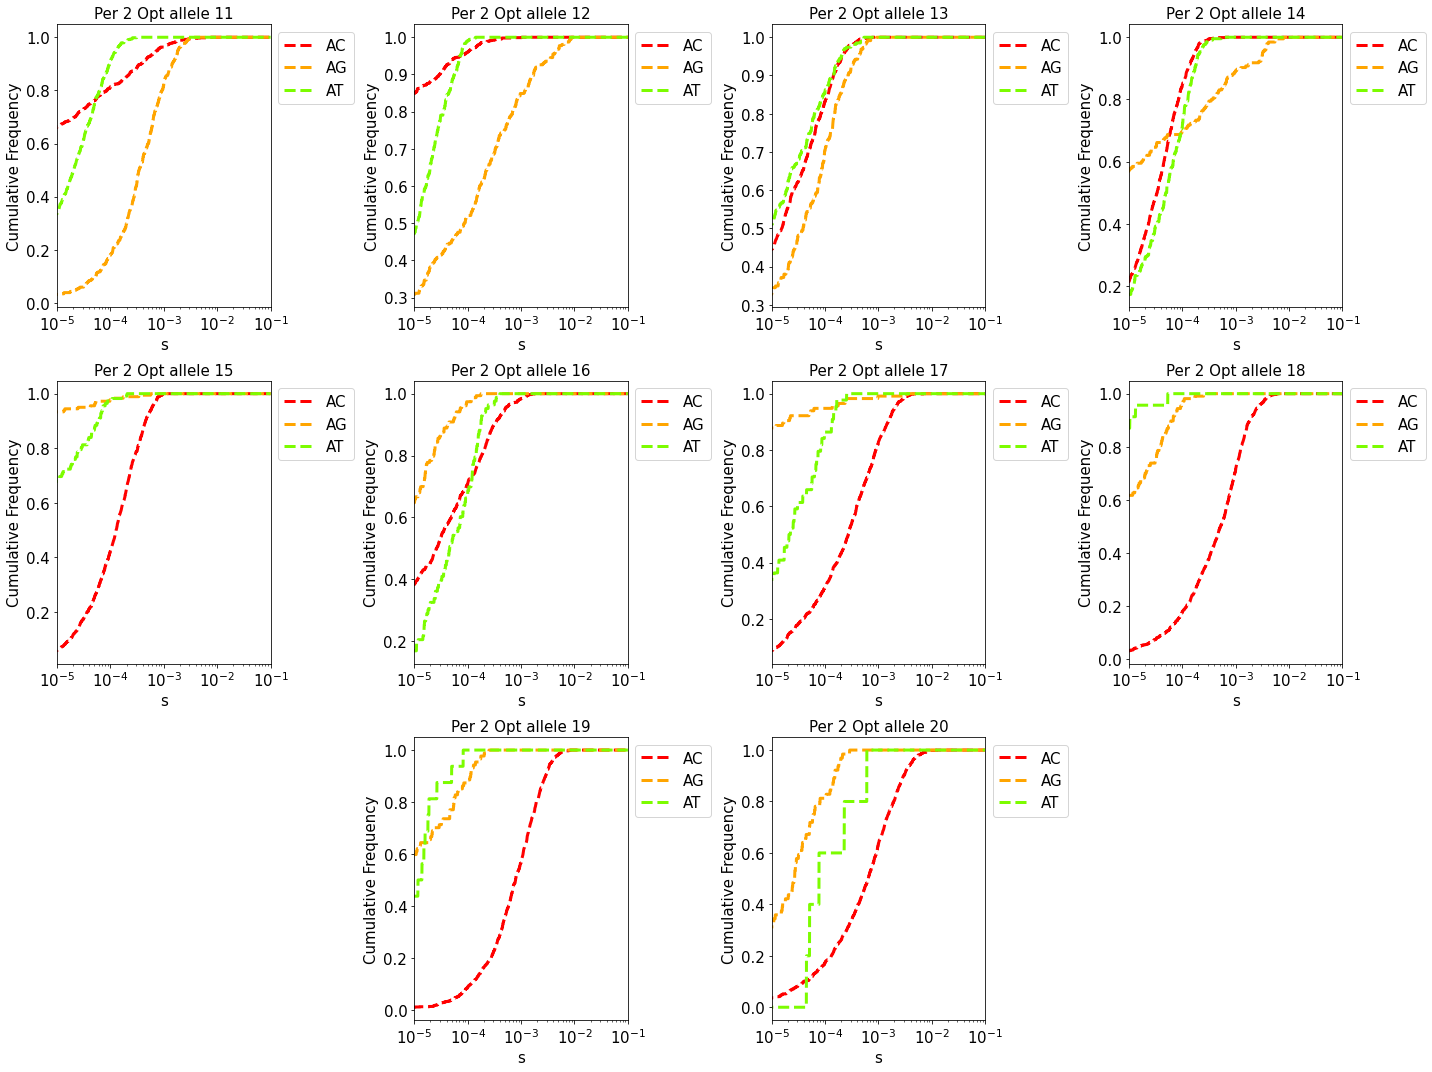

Period 3


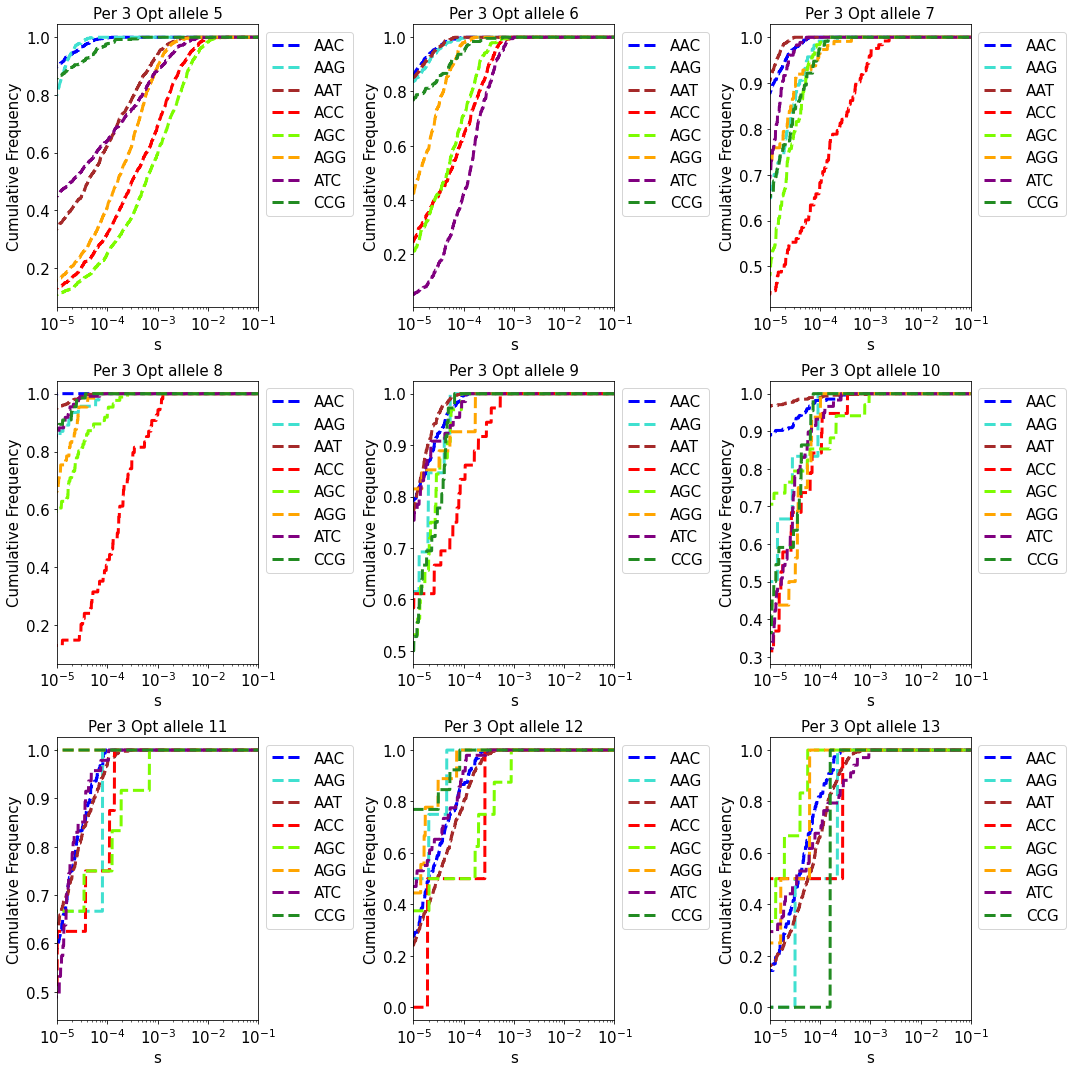

Period 4


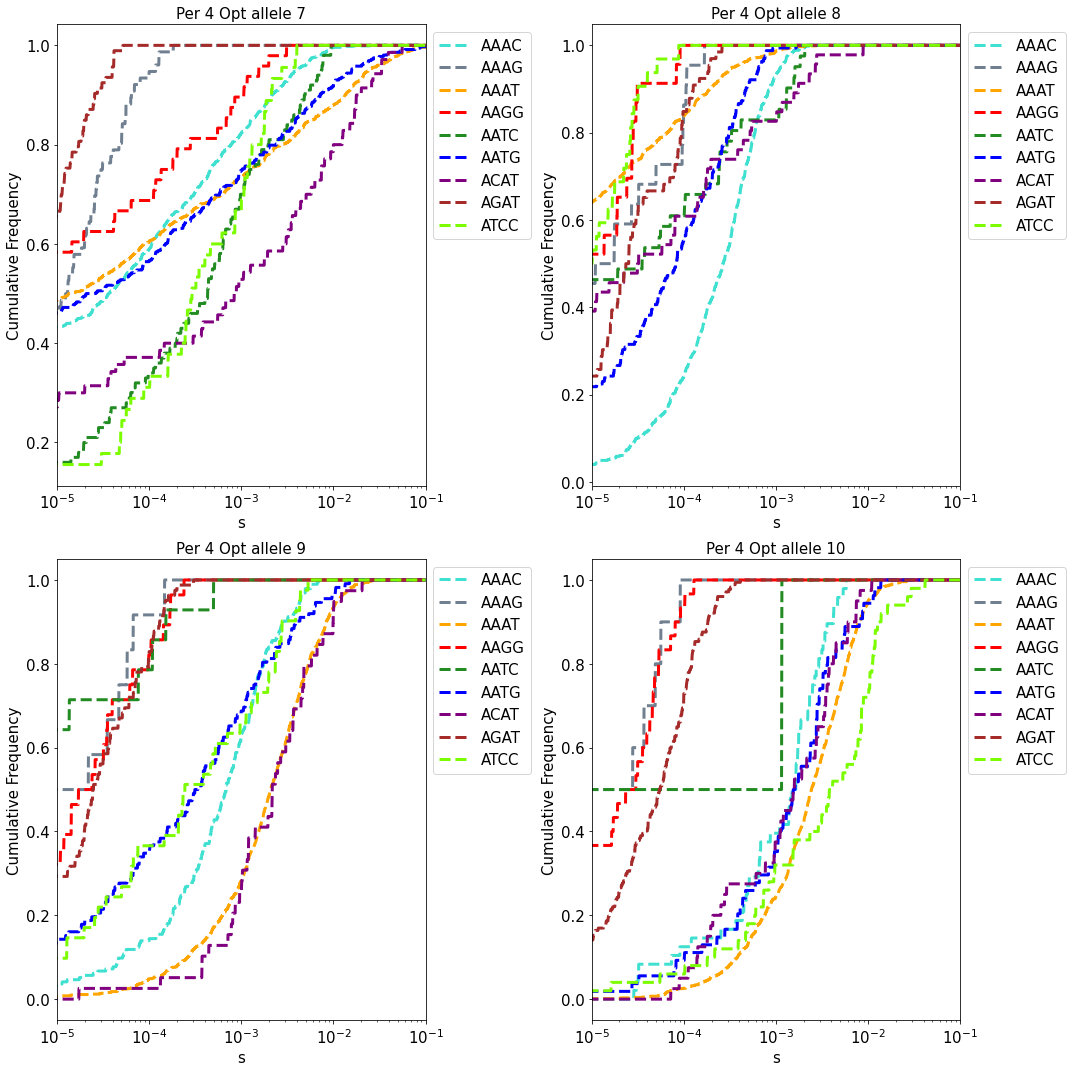

Done
CPU times: user 25 s, sys: 3.78 s, total: 28.8 s
Wall time: 24.8 s


In [3]:
%%time
if __name__ == '__main__':
    main()